The origin slide is too large to load fully into memory, as well as too large to use in common pipelines. For example, a typical Aperio SVS file for breast cancer I used is about 50000 x 50000 pixels. 

"If we tried to load such an image, in RGB space, uncompressed it would require ~7GB, making it too large to consider using in our deep learning pipelines as there wouldn' t be enough RAM on the GPU for both the data and the filter activations." (http://www.andrewjanowczyk.com/dividing-and-re-merging-large-images-humpty-dumpty/)

As a result, I try to split the image into smaller tiles. Then I can operate on them separately, and merge the images back together.

## Code

In [ ]:
import openslide
import os
import sys
import numpy as np

In [ ]:
def read_files(path: str) -> list:
    """From a dir read the .svs files, 
    then we can divide the large slide into small ones
    path: the path of all .svs files."""
    # for f in os.listdir(path):
    #     if f[-4:] == '.svs':
    #         yield os.path.join(path, f)
    return [os.path.join(path, i) for i in os.listdir(path) if i[-4:] == '.svs']

In [ ]:
def divide(slide_path: str, out_dir: str, level=1, width_rel=256, mag=0.5) -> None:
    """The origin slide is too large, 
    the function can segment the large one into small tiles.
    In this project, we set the height equals to the width.
    Slide_path: the path of the target slide; 
    level: varying definition of images, 0 is the largest, int;
    width_rel: the width and the length of output images, int.
    mag: the magnitude or the object power, float"""
    # Read slide. level 0 is mag X40, level 1 is mag X10 and so on.
    # here we downsize 400 (20*20) times  (20 = level 1 's mag X10 / mag)
    large_image = openslide.OpenSlide(slide_path)
    time = 10 / mag
    tile = width_rel * time
    # get reference and target location
    dimensions = large_image.level_dimensions
    dimension_ref = dimensions[0]
    dimension = dimensions[level]
    ratio = dimension[0] / dimension_ref[0]
    # set start points of tiles
    widths_point = list(range(0, dimension_ref[0], tile))
    heights_point = list(range(0, dimension_ref[1], tile))
    # begin segment tiles
    cwp = os.getcwd()
    case_name = os.path.basename(slide_path)[:-4]
    # print(case_name)
    out_path = os.path.join(cwp, out_dir, case_name)
    os.makedirs(out_path, exist_ok=True)
    for i, x in enumerate(widths_point):
        for j, y in enumerate(heights_point):
            # locate start point
            loc = (x, y)
            # calculate individual size
            width, height = tile, tile
            if i == len(widths_point) - 1:
                width = dimension_ref[0] - x
            if j == len(heights_point) - 1:
                height = dimension_ref[1] - y
            size = (int(width * ratio), int(height * ratio))
            # get the small image
            small_image = large_image.read_region(location=loc, 
                                                  level=level, size=size)
            # filter the useless image
            if is_useless(small_image):
                continue
            # save the small image
            height_rel = width_rel
            resize_image = small_image.resize((width_rel, height_rel))
            fp = os.path.join(out_path, '{:02d}{:02d}.png'.format(j, i))
            resize_image.save(fp)

In [ ]:
def is_useless(image) -> bool:
    """Help to judge whether the small image is informative.
    If a image has more information, it should be darker in gray mode.
    image: a Pillow object"""
    # if the width different from the height, it's the marginal part.
    if image.width != image.height:
        return True
    gray = image.convert("L")
    # 230 is a magic number, and it is not good. However, currently, 
    # I haven't found a better way
    # to select the informative images.
    return np.mean(gray) > 230

In [ ]:
def show_progress(cur_done: int, total: int, status='', bar_length=60):
    """Show the progress on the terminal.
    cur_done: the number of finished work;
    totoal: the number of overall work;
    status: trivial words, str;
    bar_length: the length of bar showing on the screen, int."""
    percent = cur_done / total
    done = int(percent * bar_length)
    show = '=' * done + '/' * (bar_length - done)
    sys.stdout.write('[{}] {:.2f}% {}'.format(show, percent*100, status))
    sys.stdout.flush()

In [ ]:
def main():
    path = sys.argv[1]
    slides = read_files(path)
    work_load = len(slides)
    done = 0
    out_dir = sys.argv[2]
    for slide_path in slides:
        divide(slide_path, out_dir)
        done += 1
        show_progress(done, work_load, status='Please wait')

In [ ]:
if __name__ == '__main__':
    main()

## Outcome Examples

In [1]:
import cv2
import matplotlib.pyplot as plt
from os.path import join

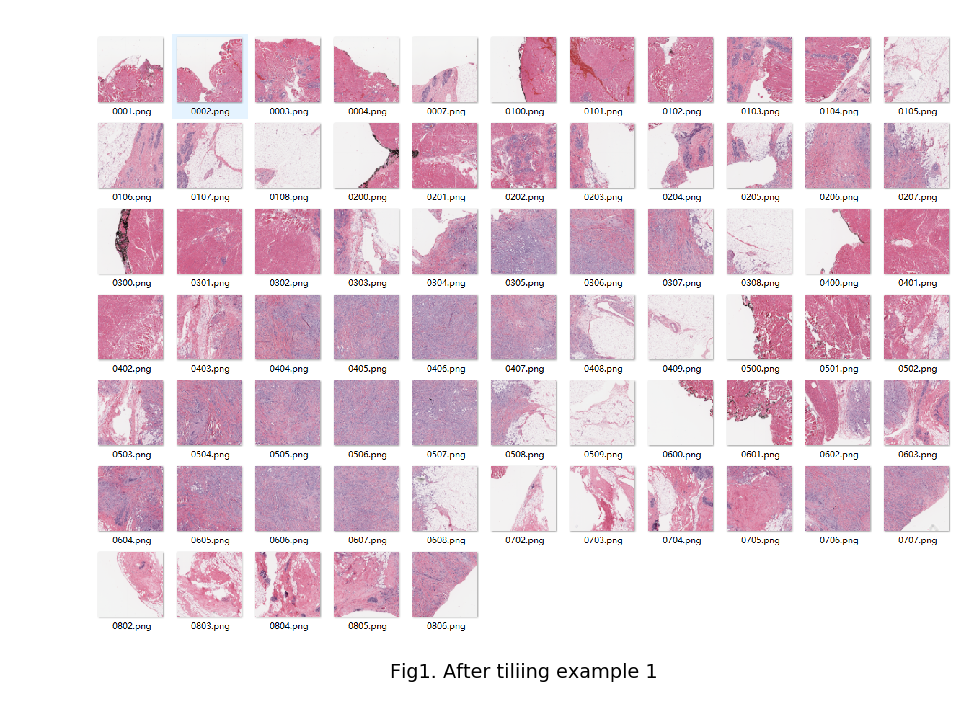

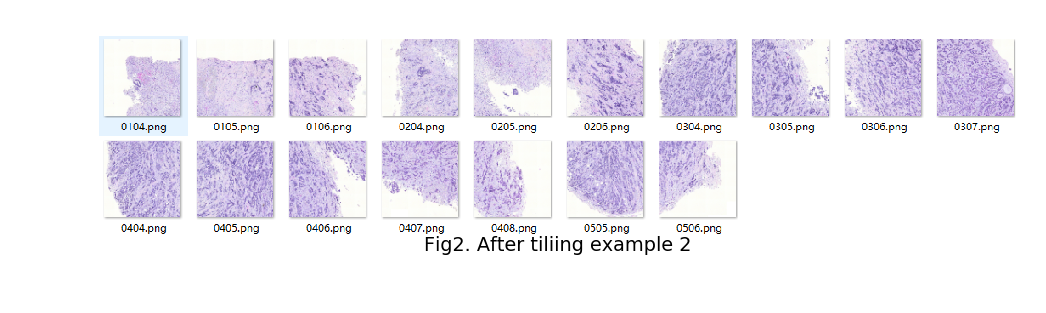

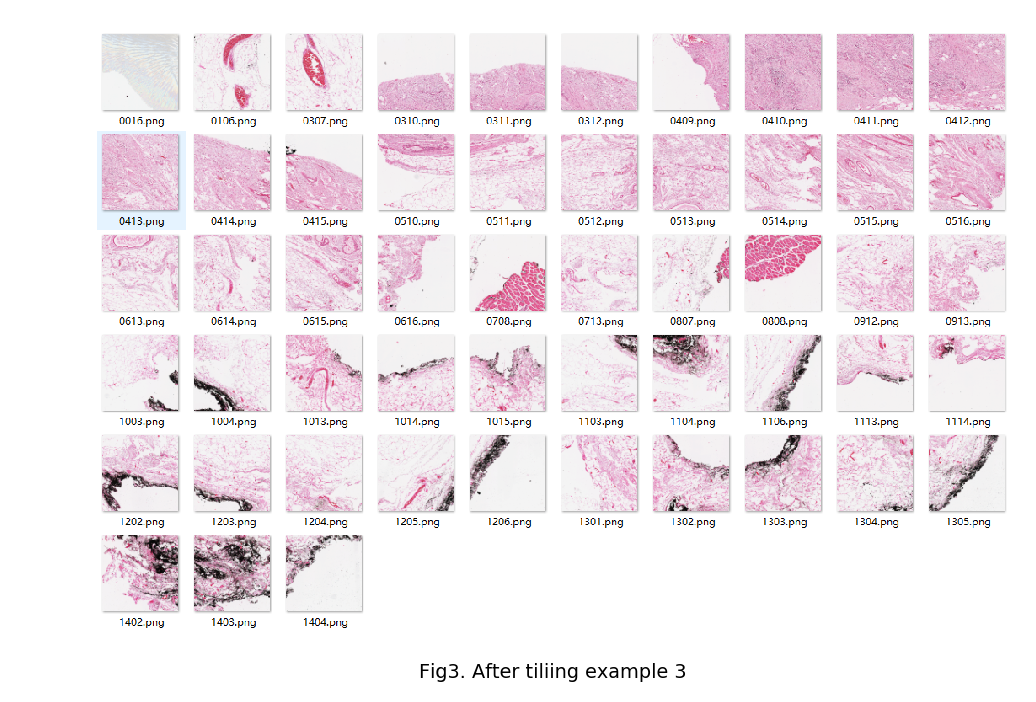

In [2]:
dir_path = "../examples/"
for i in range(1, 4, 1):
    f_name = str(i) + '.png'
    f_path = join(dir_path, f_name)
    img = cv2.imread(f_path)
    fig, ax = plt.subplots(dpi=200)
    plt.axis('off')
    size = fig.get_size_inches()
    title = "Fig{0}. After tiliing example {0}".format(i)
    ax.set_title(title,  {'fontsize':"x-small"}, y=-size[1]/40)
    plt.imshow(img[...,::-1])